In [56]:
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib.style as style
import time

In [90]:
style.use('fivethirtyeight')
imputed = 'PATIENT_DATA_ALL_3.csv'
non_imputed = 'filename_2.txt'

#merged = np.genfromtxt(imputed, delimiter='\t')
merged = pd.read_csv(imputed, sep='\t', )
labels = pd.read_csv('OLD_DATA/data_clinical_sample_clean.tsv', sep='\t')

labels.set_index('SAMPLE_ID', inplace=True)
labels.drop(['Unnamed: 0'], axis=1, inplace=True)

merged.drop('PATIENT_ID', axis=1,inplace=True)
#merged.drop('SAMPLE_ID', axis=1,inplace=True)

merged.drop(['Unnamed: 0'], axis=1,inplace=True)
merged.drop(['ONCOTREE_CODE'], axis=1, inplace=True)
#merged = merged.transpose()
merged.set_index('SAMPLE_ID', inplace=True)
merged.sort_index(inplace=True)

labels = labels['ONCOTREE_CODE']
labels.sort_index(inplace=True)

labels = labels[labels.index.str.contains("MBC-MBCProject_43UpSwhz-Tumor-SM-DL4W8") == False]

random_indices = np.random.permutation(len(labels))

X_randomized = merged.iloc[random_indices]
Y_randomized = labels.iloc[random_indices]

X = X_randomized.as_matrix() 
Y = Y_randomized.as_matrix()

X_train, y_train = X[:60], Y[:60]
X_test, y_test = X[60:], Y[60:]

In [87]:
merged.columns

Index(['AGE_AT_DIAGNOSIS_GROUP', 'CALC_TIME_TO_METS_DX_DAYS',
       'HORMONE_RECEPTOR_STATUS', 'HER2_STATUS_REPORTED', 'TRIPLE_NEG_STATUS',
       'INFLAMMATORY_STATUS', 'HISPANIC', 'RACE_CATEGORIZED',
       'T_STAGE_REPORTED', 'N_STAGE_REPORTED', 'DX_SIDEDNESS', 'DX_HISTOLOGY',
       'DX_GRADE', 'SURGERY_AT_DX', 'ADJ_XRT', 'METS_SITES_AT_METS_DX_ASCITES',
       'METS_SITES_AT_METS_DX_BONE', 'METS_SITES_AT_METS_DX_BRAIN_CNS',
       'METS_SITES_AT_METS_DX_CHEST_WALL',
       'METS_SITES_AT_METS_DX_INTRA_ABDOMINAL', 'METS_SITES_AT_METS_DX_LIVER',
       'METS_SITES_AT_METS_DX_LUNG', 'METS_SITES_AT_METS_DX_REG_LYMPH',
       'METS_SITES_AT_METS_DX_DIST_LYMPH', 'METS_SITES_AT_METS_DX_OVARY',
       'METS_SITES_AT_METS_DX_PLEURAL_EFFUSION', 'METS_SITES_AT_METS_DX_SKIN',
       'METS_SITES_AT_METS_DX_SOFT_TISSUE',
       'METS_SITES_AT_METS_DX_ADRENAL_GLAND', 'METS_SITES_AT_METS_DX_UNKNOWN',
       'METS_SITES_AT_METS_ABST_ASCITES', 'METS_SITES_AT_METS_ABST_BONE',
       'METS_SITES_AT_

Dataset 2CN, train_samples=60, n_features=58, n_classes=4
Using l1 regression
[model=One versus Rest, solver=liblinear] Number of epochs: 1
[model=One versus Rest, solver=liblinear] Number of epochs: 3
Test accuracy for model ovr: 0.7619
Train accuracy for model ovr: 0.8500
% non-zero coefficients for model ovr, per class:
 [ 32.75862069  37.93103448  36.20689655  39.65517241]
Run time (3 epochs) for model ovr:0.00
Example run in 0.093 s


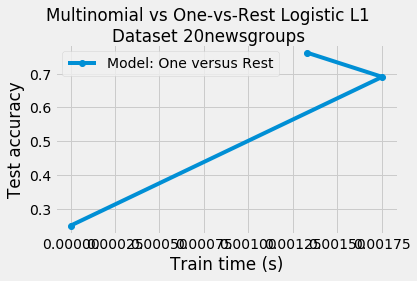

In [91]:
# Turn down for faster run time

n_samples = 10000

t0 = time.clock()

penalty = 'l1'

train_samples, n_features = X_train.shape
n_classes = np.unique(Y).shape[0]

print('Dataset 2CN, train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

# Solver which handles multiclass and l1 penalty
solver = 'newton-cg'

if penalty == 'l1':
    print('Using l1 regression')
    models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3]}}
    solver = 'liblinear'
    
for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    tr_accuracies = [1/n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                C=1,
                                penalty=penalty,
                                fit_intercept=True,
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = time.clock()
        lr.fit(X_train, y_train)
        train_time = time.clock() - t1
        times.append(train_time)
        tr_accuracy = np.sum(y_train == lr.predict(X_train)) / y_train.shape[0]

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        tr_accuracies.append(tr_accuracy)
        densities.append(density)
        
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    models[model]['tr_accuracies'] = tr_accuracies
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('Train accuracy for model %s: %.4f' % (model, tr_accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = time.clock() - t0
print('Example run in %.3f s' % run_time)
plt.show()

In [78]:
y_pred

array([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 3, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1])